# Hot 100 Network Analysis
#### Social Graphs & Interactions Final Project

# Contents

This notebook contains four main sections:
- Motivation
- EDA & Data preparation
- Artist Network
- Rank score assortativity with respect to features
- Rank score assortativity with respect to lyrics
- Data scraping

We have put the data scraping in the bottom of the notebook, as the scrape takes a really long time to conduct (+24 hours), so should not be executed unless necesarry. All files have been saved, ad will be loaded with the assumption that the file is stored in the same directory as the notebook (everything is relative paths)

### Section links:

- [Motivation](#chapter1)
- [EDA & Data preparation](#EDA_&_data_preparation)
    - [Basic Statistics](#Basic_Statistics)
- [Artist Network](#artist_network)
- [Assortivity between features and artist attributes](#Assortativity_features)
    - [Assortivity between features and Rank Score](#Assortativity_features_rank_score)
    - [Assortativity between features and Genre](#Genre_features)
- [Assortivity between lyrics similarity and artist attributes](#Lyrics_assortativity)
    - [Backboning](#Backboning)
    - [Assortivity between lyrics similarity and Rank Score](#Assortativity_lyrics_rank_score)
    - [Assortativity between lyrics similarity and Genre](#Assortativity_lyrics_rank_score)
- [Data Scraping](#scraping)
    - [Lyrics Scraping](#lyrics_scraping)
    - [Genres Scraping](#genres_scraping)

### Datasets:

- Billboard hot 100: All billboard hot 100 songs for every week, since 1995

- Lyrics: Lyrics for all songs in the billboard hot 100 dataset

- Genres: Genres for all artists in the billboard hot 100 dataset


# Motivation <a class="anchor" id="chapter1"></a>

**The Motivation**
Music is part of us all, the rhythm and beat patterns create emotions, memories and feelings for any human being. With the modernization of society, the music industry has grown to become a billion-dollar sector of the economy. Even coming from such an abstract art form, we are left wondering how artists and songs enter into the history of society, how we can determine what a "hit" is. Do artists and musicians have total control over how they can become famous? Luckily for us, there are companies that record every week what were the most played songs, and we have data for almost 100 years containing song, artist and what was the rank among the top [100 hottest songs](https://www.billboard.com/charts/hot-100/).


**The goal**
The purpose of this project is to try to analyze if there is a formula for success among the most listened to songs. Furthermore, we are also interested in understanding the influence of artists on other artists and to analyze what is the degree of rapport between different genres, artists and how they put together their lyrics. Finally, as we have a large amount of data, we will perform a sentiment analysis on each song to visualize any patterns 


#### Import all necesarry libraries

In [4]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
from fa2 import ForceAtlas2
import networkx.algorithms.community as nxcom
import datetime 
import matplotlib.colors as colors
import powerlaw
import collections
import random
import community
import os 
import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob


from matplotlib.pyplot import figure
from matplotlib.lines import Line2D
import statistics as stats
import itertools
import pickle
from scipy import integrate
import glob
import spacy
import warnings
warnings.simplefilter('ignore')
%matplotlib inline
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'figure.figsize': (15, 10)})

<a id='EDA_&_data_preparation'></a>
# EDA & Data Preparation

#### Billboard hot 100 

In this cell the billboard hot 100 file is loaded. A lot of cleaning is necessary, as songs (especially feautures) are formatted differently. The resulting DF (simply called 'df'), will be our source for most of the project, however there will be many different version, i.e. 'lyrics_df', which is supplemented with lyrics data from Genius.

The dataset consists of the 100 most sold songs weekly since 1958


In [5]:
#The original billboard hot 100 csv
df = pd.read_csv('charts.csv')
df

date  rank                                 song  \
0       2021-11-06     1                           Easy On Me   
1       2021-11-06     2                                 Stay   
2       2021-11-06     3                        Industry Baby   
3       2021-11-06     4                           Fancy Like   
4       2021-11-06     5                           Bad Habits   
...            ...   ...                                  ...   
330082  1958-08-04    96                        Over And Over   
330083  1958-08-04    97                     I Believe In You   
330084  1958-08-04    98                      Little Serenade   
330085  1958-08-04    99  I'll Get By (As Long As I Have You)   
330086  1958-08-04   100                                 Judy   

                               artist  last-week  peak-rank  weeks-on-board  
0                               Adele        1.0          1               3  
1       The Kid LAROI & Justin Bieber        2.0          1              16  
2             Lil Nas X & Jack Harlow        3.0          1              14  
3                        Walker Hayes        4.0          3              19  
4                          Ed Sheeran        5.0          2              18  
...                               ...        ...        ...             ...  
330082                Thurston Harris        NaN         96               1  
330083                Robert & Johnny        NaN         97               1  
330084              The Ames Brothers        NaN         98               1  
330085                 Billy Williams        NaN         99               1  
330086                Frankie Vaughan        NaN        100               1  

[330087 rows x 7 columns]

In [6]:
#deleting () on the dataframe for splitting
df['artist'] = df['artist'].str.replace(r"\(.*\)","")

#converting date to dateframe
df['year'] = pd.to_datetime(df['date'], format='%Y-%m-%d').dt.year

#renaming artist column for a more appropriate version
df = df.rename(columns={"artist": "Raw_artist"})

#filterning songs containing Lil Nas X (the reason is the symbol X is used for features and hes the only artist with this name)
df_err_artists = df[df['Raw_artist'].str.contains("Lil Nas X|Genius/GZA|Shay")]

#splitting to get the correct features
df_err_splitted  = df_err_artists['Raw_artist'].str.split(r'Featuring|presents|\sOr\s|Feat.|\sx\s|,|Duet With|\s\/\s|With|And|with|Introducing|:|Starring|&', expand = True).add_prefix('artist_')

#joining both dataframes
df_err_artists= df_err_artists.join(df_err_splitted)

#filtering Lil Nas X from dataframe to not worse our analysis
df = df[~df['Raw_artist'].str.contains("Lil Nas X|Genius/GZA|Shay")]

#filtering songs after 1980 - until then the music industry had many duos using & but after that period & were being used as a Colab symbol
df_new_songs = df[df['year'].between(1980, 2021)]

#splitting Raw artists in Features using only for new songs
df_new_songs_ = df_new_songs['Raw_artist'].str.split(r'\sX\s|Featuring|\sOr\s|spresents|Feat.|\sx\s|,|\s+\s|Duet With|\/|With|\sAnd\s|with|Introducing|:|Starring|&', expand = True).add_prefix('artist_')

#joining both dataframes
df_new_songs= df_new_songs.join(df_new_songs_)

#doing the same for old songs
df_old_songs = df[df['year'].between(min(df.year), 1979)]

#splitting Raw artists in Features using only for old songs
df_old_songs_ = df_old_songs['Raw_artist'].str.split(r'\sX\s|Featuring|\sOr\s|\sAnd\s|presents|Feat.|\sx\s|\s+\s|Duet With|\/|With|with|Introducing|:|Starring', expand = True).add_prefix('artist_')

#joining both dataframes
df_old_songs= df_old_songs.join(df_old_songs_)

#concat old and new songs to one data frame
df_all_songs = pd.concat([df_new_songs, df_old_songs])

#concat all columns to the rest of features
df = pd.concat([df_all_songs,df_err_artists ], ignore_index=True)

#cleaning spaces
df = df.replace(r"^ +| +$", r"", regex=True)

#switching NaN to None
df = df.where(pd.notnull(df), None)

# Create an empty list
Row_list =[]
  
# Iterate over each row
for index, rows in df.iterrows():
    # Create list for the current row
    my_list =[rows.artist_1, rows.artist_2, rows.artist_3, rows.artist_4, rows.artist_5, rows.artist_6, rows.artist_7, rows.artist_8, rows.artist_9]
      
    # append the list to the final list
    Row_list.append(my_list)
    
#appending values in a list per row
df['features'] = Row_list
df['features'] = df.features.apply(lambda x: [i for i in x if i != None])

df['n_features'] = df['features'].apply(lambda x: len(x))

#dropping useless columns (artist_n)
df = df[['rank', 'song', 'Raw_artist', 'artist_0','features','n_features', 'year']]

In [7]:
#The main billboard hot 100 data source with the correct splitting
df

rank           song                           Raw_artist  \
0          1     Easy On Me                                Adele   
1          2           Stay        The Kid LAROI & Justin Bieber   
2          4     Fancy Like                         Walker Hayes   
3          5     Bad Habits                           Ed Sheeran   
4          6     Way 2 Sexy  Drake Featuring Future & Young Thug   
...      ...            ...                                  ...   
330082    80  Liquid Swords                           Genius/GZA   
330083    66  Liquid Swords                           Genius/GZA   
330084    48  Liquid Swords                           Genius/GZA   
330085    56  Liquid Swords                           Genius/GZA   
330086    66  Liquid Swords                           Genius/GZA   

             artist_0              features  n_features  year  
0               Adele                    []           0  2021  
1       The Kid LAROI       [Justin Bieber]           1  2021  
2        Walker Hayes                    []           0  2021  
3          Ed Sheeran                    []           0  2021  
4               Drake  [Future, Young Thug]           2  2021  
...               ...                   ...         ...   ...  
330082     Genius/GZA                    []           0  1995  
330083     Genius/GZA                    []           0  1995  
330084     Genius/GZA                    []           0  1995  
330085     Genius/GZA                    []           0  1995  
330086     Genius/GZA                    []           0  1995  

[330087 rows x 7 columns]

<a id='Basic_Statistics'></a>
## Basic Statistics

To start, let's understand the data, this includes:

* Number of Songs, artists and unique songs since 1958
* Number of Feat. per song
* The top Artists by ranking
* Music Genre Sales from 1995 onwards

The hot 100 billboard data starts in year 1958 and continues until year 2021. In these years, 330087 songs have been on the list, in which only 24619 were unique.

In [8]:
#Number of songs
print('Number of songs:', len(df.song))
# Number of unique songs
print('Number of unique songs:', len(set(df.song)))
# The dates of the billboard data 
print('Min. year: ', min(df.year), 'Max. year: ', max(df.year))

Number of songs: 330087
Number of unique songs: 24619
Min. year:  1958 Max. year:  2021


In [9]:
print('Number of distinct artist:', len(set(df.artist_0)))

Number of distinct artist: 7401


### Number of Features Throughout the Years

As features is a key element in creating the edges of our network, let take a look at how the number of features develops over the years:

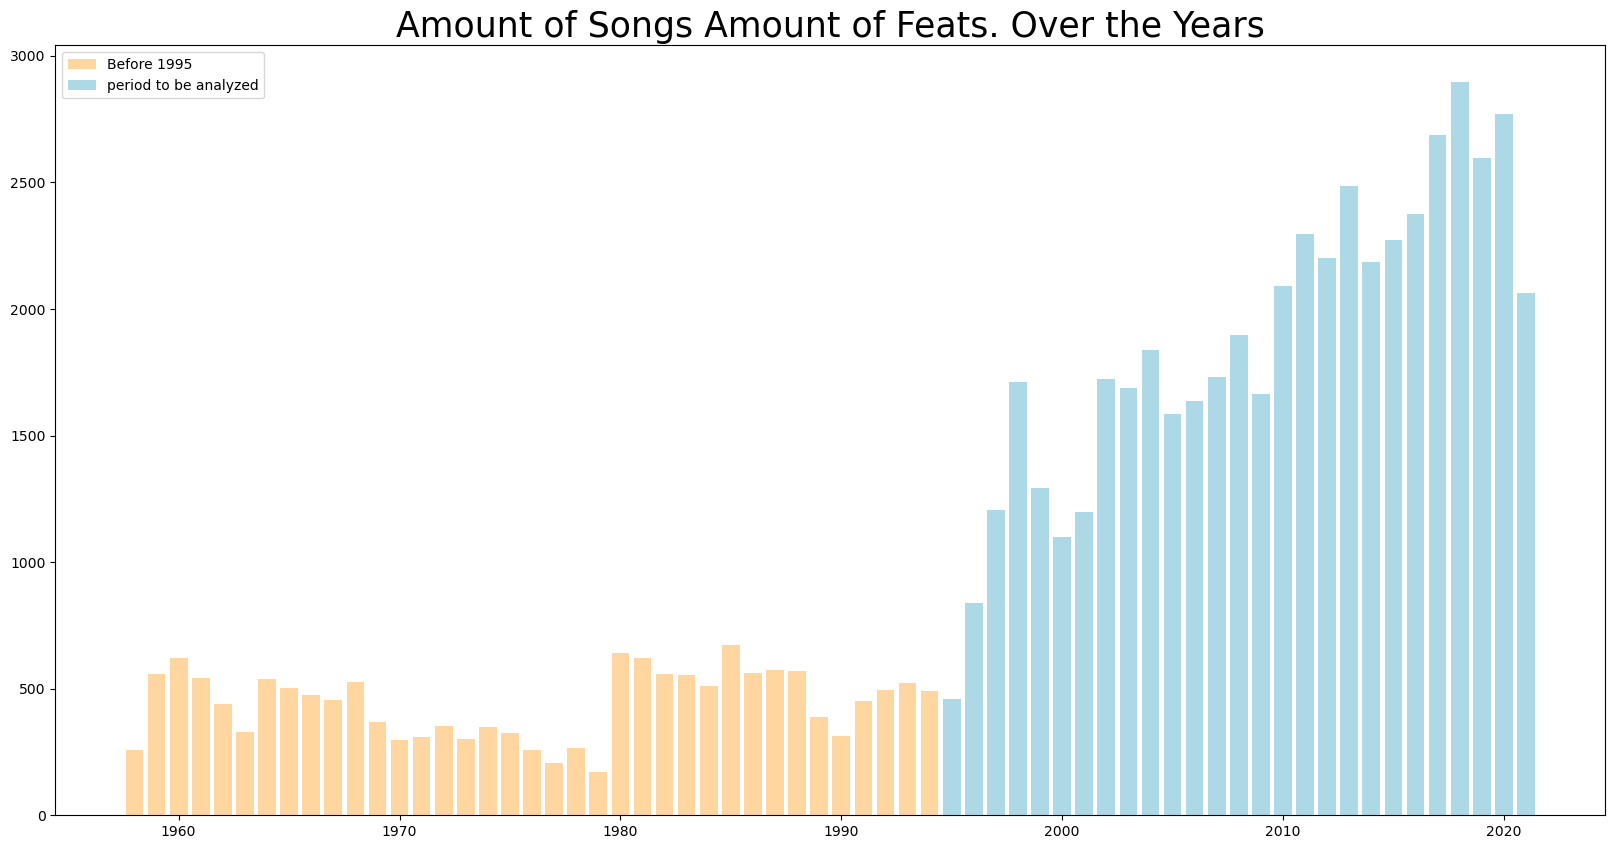

In [14]:
#filtering dataset to 1995
df_plot_features = df[df['year'] >= 1995]
df_plot_features['query'] = df_plot_features['Raw_artist'] + "_" + df_plot_features['song']
df_plot_features =  df_plot_features.drop_duplicates(subset=['query'])
df_plot_features = df.groupby(['year']).sum().reset_index()
df_plot_features = df_plot_features.drop(['rank'], axis=1)

x = df_plot_features.year
y = df_plot_features.n_features
#filtering for the period to be analyzed
mask1 = x <= 1994
mask2 = x >= 1995



fig = plt.gcf()
fig.set_size_inches(20, 10)


ax1 = plt.bar(x[mask1], y[mask1], color = ['#FFD5A0'])
ax2 = plt.bar(x[mask2], y[mask2], color = 'lightblue')
plt.title('Amount of Songs Amount of Feats. Over the Years', size = 25)
#assigning legends for the plot
period = ['Before 1995','period to be analyzed']
plt.legend(period,loc=2)
plt.show()


In the above visualization, the number of featured song over the years is spiked. According to the plot, the surge of featured songs began around the year 1995. As stated in the project's motivation, the main goal is to create a network that connects artists depending on whether or not they have collaborated. 

**Based on the plot above, the decision was made to filter the dataset such that it only contained data from 1995 and up.**

In [10]:
#Filte the data based on year
df=df[df['year']>1995]
#Create a list that contain everyone involved in the song (main artist + features artist(s))
df['artist_list'] = df['artist_0'].apply(lambda x: [x])
df['all_artists']=df['artist_list']+df['features']
df['all_artists'] = df['all_artists'].apply(lambda x: [i for i in x if i !=''])
df

rank          song                           Raw_artist  \
0          1    Easy On Me                                Adele   
1          2          Stay        The Kid LAROI & Justin Bieber   
2          4    Fancy Like                         Walker Hayes   
3          5    Bad Habits                           Ed Sheeran   
4          6    Way 2 Sexy  Drake Featuring Future & Young Thug   
...      ...           ...                                  ...   
330074    67  Shadowboxin'      Genius/GZA Featuring Method Man   
330075    72  Shadowboxin'      Genius/GZA Featuring Method Man   
330076    89  Shadowboxin'      Genius/GZA Featuring Method Man   
330077   100    Cold World  Genius/GZA Featuring Inspektah Deck   
330078   100    Cold World  Genius/GZA Featuring Inspektah Deck   

             artist_0              features  n_features  year  \
0               Adele                    []           0  2021   
1       The Kid LAROI       [Justin Bieber]           1  2021   
2        Walker Hayes                    []           0  2021   
3          Ed Sheeran                    []           0  2021   
4               Drake  [Future, Young Thug]           2  2021   
...               ...                   ...         ...   ...   
330074     Genius/GZA          [Method Man]           1  1996   
330075     Genius/GZA          [Method Man]           1  1996   
330076     Genius/GZA          [Method Man]           1  1996   
330077     Genius/GZA      [Inspektah Deck]           1  1996   
330078     Genius/GZA      [Inspektah Deck]           1  1996   

            artist_list                     all_artists  
0               [Adele]                         [Adele]  
1       [The Kid LAROI]  [The Kid LAROI, Justin Bieber]  
2        [Walker Hayes]                  [Walker Hayes]  
3          [Ed Sheeran]                    [Ed Sheeran]  
4               [Drake]     [Drake, Future, Young Thug]  
...                 ...                             ...  
330074     [Genius/GZA]        [Genius/GZA, Method Man]  
330075     [Genius/GZA]        [Genius/GZA, Method Man]  
330076     [Genius/GZA]        [Genius/GZA, Method Man]  
330077     [Genius/GZA]    [Genius/GZA, Inspektah Deck]  
330078     [Genius/GZA]    [Genius/GZA, Inspektah Deck]  

[134900 rows x 9 columns]

### The Top Artists of All Time

It is interesting to analyze which were the most outstanding artists during these almost 80 years, the standard ranking provided by Billboard is a count of weeks that a song or artist has owned, however we believe we can take a step further and try to understand which were the [G.O.A.T](https://en.wikipedia.org/wiki/Greatest_of_All_Time) artists of the century, and divide for the modern era (from our analysis in 1995 to the most current days)

In [11]:
#filtering only the top 10 of all time
print('The Top 10 Artists with the most Hot 100 songs apperances are:')
(df[['artist_0']].value_counts(ascending = False)[:10])

The Top 10 Artists with the most Hot 100 songs apperances are:


artist_0     
Drake            1494
Taylor Swift     1131
Kenny Chesney     921
Rihanna           916
Chris Brown       870
Keith Urban       771
Tim McGraw        769
Maroon 5          757
Usher             714
Beyonce           704
dtype: int64

In [13]:
#filtering only the top 10 from the "Modern Era" (1995- present)
print('The Top 10 Artists with the Most Hot 100 songs apperances of the Modern Era are:')
(df[['artist_0']].value_counts(ascending = False)[:10])

The Top 10 Artists with the Most Hot 100 songs apperances of the Modern Era are:


artist_0     
Drake            1494
Taylor Swift     1131
Kenny Chesney     921
Rihanna           916
Chris Brown       870
Keith Urban       771
Tim McGraw        769
Maroon 5          757
Usher             714
Beyonce           704
dtype: int64

This is very interesting! It seems Drake is the artist with more singles in the ranking, however some names from past decades are still very strong (Elvis Presley, Madonna, Elton John etc...), will it be that if we consider the position in the chart and the number of weeks this ranking will change?

In [14]:
#duplicating dataframe
df_goat = df 
#inverting rank to show that who has the highest number is the most famous one
df_goat['rank']=101-df_goat['rank']
#grouping to get all ranking sums
df_goat = df_goat.groupby('artist_0').sum()
#better visualization for the dataframe
df_goat = df_goat.reset_index()
#sorting values of rank
df_goat = df_goat.sort_values(by='rank', ascending=False)
df_goat = df_goat.drop(['n_features', 'year'], axis = 1)
df_goat = df_goat[:10]

                       
print('The Top 10 G.O.A.T Artists are:')
print(df_goat.to_string(index=False))


The Top 10 G.O.A.T Artists are:
     artist_0   rank
        Drake  85915
 Taylor Swift  68965
      Rihanna  62711
     Maroon 5  55275
  Chris Brown  51126
        Usher  50054
  Post Malone  41461
         P!nk  40927
   The Weeknd  40463
   Katy Perry  40431


In [15]:
#duplicating dataframe
df_goat = df 
#inverting rank to show that who has the highest number is the most famous one
df_goat['rank']=101-df_goat['rank']
#filtering for songs after 1995
df_goat = df_goat[df_goat['year'] >= 1995]
#grouping to get all ranking sums
df_goat = df_goat.groupby('artist_0').sum()
df_goat = df_goat.reset_index()
#sorting values of rank
df_goat = df_goat.sort_values(by='rank', ascending=False)
df_goat = df_goat.drop(['n_features', 'year'], axis = 1)
df_goat = df_goat[:10]

                       
print('The Top 10 G.O.A.T  of Modern Era Artists are:')
print(df_goat.to_string(index=False))


The Top 10 G.O.A.T  of Modern Era Artists are:
      artist_0   rank
         Drake  64979
 Kenny Chesney  55749
   Keith Urban  48703
    Tim McGraw  45275
  Taylor Swift  45266
  Brad Paisley  40779
  Jason Aldean  38436
 Blake Shelton  37319
 Rascal Flatts  37268
   Chris Brown  36744


**Comments regarding the artist ranking:** Really impressive, from the ranking we made. Drake is an artist in another league, both in number of appearances and high positions he stands out

### Number of Songs by Genre Throughout 1995

As we are emphasizing this more current moment in music (post 90's) and also visualizing this large number of collaborations between artists for songs, we want to understand if the genre of music had any influence on this. Has the listener's preferred genre changed over the years? It is possible to see that the Hot 100 list does not provide the genre of the song or artist, however, through web [scrapping](https://www.allmusic.com/), we can extract the main genre of a musician to understand if the relationships of their style influences their collaboration.





In [16]:
#importing genres dataset (available in the bottom part with the web scrapping section)
genres = pd.read_csv('artists_genre.csv', usecols = ['artist','genre'])
genres = genres.rename(columns={"artist": "artist_0"})


#calling main dataframe and groupping values for single songs and artists
df_95_plot = df
df_95_plot= df_95_plot[df_95_plot['year'] >= 1995]
df_95_plot = pd.merge(df_95_plot,genres[['artist_0','genre']],on='artist_0', how='left')
df_95_plot['query'] = df_95_plot['Raw_artist'] + df_95_plot['song']
df_95_plot = df_95_plot.drop_duplicates(['query'],keep='first')


#creating plot dataframe grouping by year and genre
genre_plot = df_95_plot.groupby(['year','genre']).count().reset_index()
genre_plot = genre_plot.drop(['song','Raw_artist','artist_0','features','n_features','query'], axis=1)

genre_plot.pivot_table(index='year',values='rank',aggfunc='sum').plot()

In [17]:
#extracting only the top 3 genres of the latest year
genre_grouping = genre_plot[genre_plot['year'] == 2021]

#sorting columns top get the highest values
genre_grouping = genre_grouping.sort_values('rank', ascending = False)

#getting top 3 genres
genre_top3 = list(genre_grouping.genre[:3].copy())

#wirting new column with grouped values
#genre_plot['genre_group'] = [[f for f in genre_top3 if f in qn] for qn in genre_plot['genre']]


<a id='artist_network'></a>
# Artist Network 

Now that we understand more about the music market, we will create a network using the main artist (Main_Artist) versus artists who have collaborated with him. We set up this methodology to analyze if our network can be useful to continue our analysis of collaboration and success between artists

In [18]:
years=list(df.year.unique())
years.sort()
feauture_df=df[['artist_0','features','year']]


#We create a dictionary. The keys will be years and the values will be dictionaries containing nodes and edges
#for that year
graphs={}


for year in years:
    #get only nodes and edges which are present up until the current year we are lookinng at
    tmp_df=feauture_df[feauture_df['year']<=year]
    #Just a quick security check for nan and empty values
    tmp_df['artist_0'].replace('', np.nan, inplace=True)
    tmp_df.dropna(inplace=True)
    
    #explode frame so we get all edge pairs, and store edges and node
    artist_explode = tmp_df.explode('features').reset_index(drop=True)
    artist_explode['features'].replace('', np.nan, inplace=True)
    artist_explode.dropna(inplace=True)
    uni_edges = list(artist_explode[['artist_0','features']].itertuples(index=False, name=None))
    
    #insert into dictionary
    graphs[year]={'nodes':tmp_df['artist_0'].values,'edges':set(uni_edges)}

#creating the network    
G=nx.Graph()
#adding nodes
G.add_nodes_from(set(graphs[2021]['nodes']))
#adding edges
G.add_edges_from(set(graphs[2021]['edges']))

Since we already have our network base, we will do some experiments. First we will check with direct and indirect networks, the first to understand how an artist collaborates and receives collaborations

In [19]:
# Make a network
artists_network = nx.DiGraph()

# Add egdes
artists_network.add_edges_from(set(graphs[2021]['edges']))

# Discard isolated nodes
artists_network.remove_nodes_from(list(nx.isolates(artists_network)))

In [20]:
# Extract the giant connected component
gcc = artists_network.subgraph(max(nx.weakly_connected_components(artists_network), key=len))

In [21]:
# Lenght of nodes and edges, and the value of p (p = probability for edge creation)
gcc_nodes = len(gcc.nodes)
gcc_edges = len(gcc.edges)
p = gcc_edges/(gcc_nodes*(gcc_nodes-1))
print('The total number of nodes is: ',gcc_nodes)
print('The total number of links is: ',gcc_edges)
print('The probability for edge creation is:', round(p,4))

The total number of nodes is:  1513
The total number of links is:  3223
The probability for edge creation is: 0.0014


In [22]:
# create the random network
random_network = nx.fast_gnp_random_graph(gcc_nodes, p, directed=True)

In [23]:
# Find the in and out degree for the artist network
degree_in = list(dict(gcc.in_degree()).values())
degree_out = list(dict(gcc.out_degree()).values())
# Find the degree for the random network
degree_random = list(dict(random_network.degree()).values())

In [24]:
# Find the count of the degrees
degree_count_in = pd.Series(degree_in).value_counts()
degree_count_out = pd.Series(degree_out).value_counts()
degree_count_random = pd.Series(degree_random).value_counts()

In [25]:
# Find the top 5 in-degree
top_indegree = sorted(dict(gcc.in_degree()).items(), key=lambda item: item[1], reverse=True)
print('Top 5 in-degree of the Artists network:\n')
for i in list(top_indegree[:5]):
    print(i[0],'-->',i[1])
print('\n')

# Find the top 5 out-degree
top_outdegree = sorted(dict(gcc.out_degree()).items(), key=lambda item: item[1], reverse=True)
print('Top 5 out-degree of the Artists network:\n')
for i in list(top_outdegree[:5]):
    print(i[0],'-->',i[1])

Top 5 in-degree of the Artists network:

Nicki Minaj --> 58
Lil Wayne --> 58
Drake --> 46
Chris Brown --> 42
Future --> 32


Top 5 out-degree of the Artists network:

DJ Khaled --> 54
Drake --> 47
Kanye West --> 39
Lil Wayne --> 38
Meek Mill --> 32


**In and Out Degree finding:** Once again, Drake follows at the top of the charts, both in collaborating with artists and also receiving feats. Something that makes our network even more reliable is that DJ Khaled, has the top of the collaboration rankings, the reason being that he doesn't sing and only produces the beats, and it takes artists to produce music

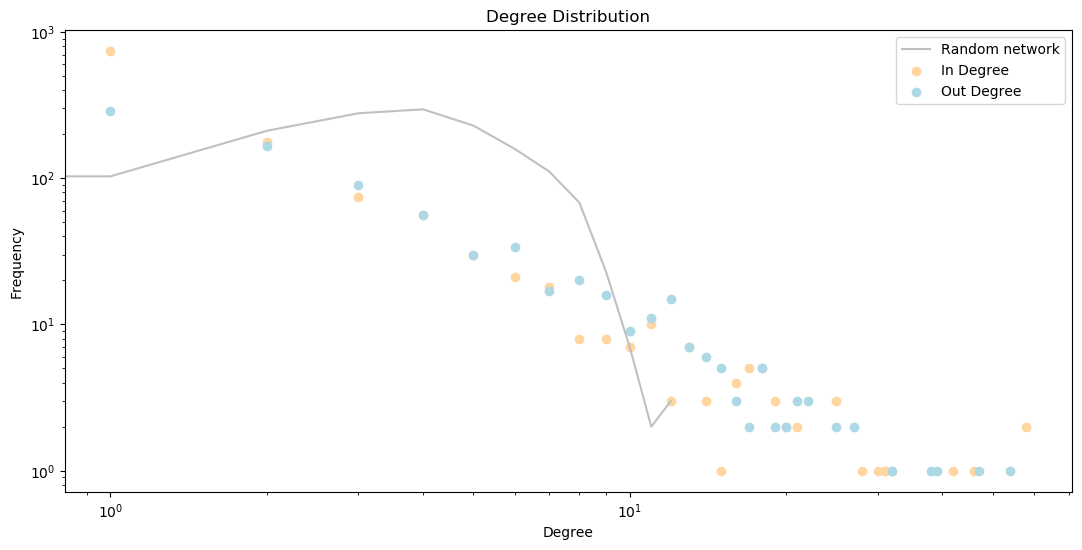

In [100]:
# Plot the in degree, out degree and random network degree
plt.figure(figsize=(13,6))
plt.title('Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Frequency')
ind = plt.scatter(degree_count_in.index, degree_count_in, color='#FFD5A0')
outd = plt.scatter(degree_count_out.index, degree_count_out, color='lightblue')
rand_argsort = np.argsort(degree_count_random.index)
totd = plt.plot(degree_count_random.index[rand_argsort], degree_count_random.iloc[rand_argsort], color='silver')
plt.legend(['Random network','In Degree', 'Out Degree',])
plt.xscale('log')
plt.yscale('log')
plt.show()

**Reading about the Artist Network**

From the figure, we see that the in-degree distribution looks a lot like a scale-free network when seen on the log-log plot. Although it is very different from the random network, we also see a slight curve in the distribution so it doesn't perfectly follow a power-law distribution, and therefore we can't declare it as a scale-free network. When we look at the out-degree, we see that it is very similar to the in-degree distribution. This is reasonable since the connections in the whole artist network are very sparse, and the artists have a similar amount of in- and out-degree, which encourages us to look further into a specific universe inside the whole network

In [27]:
#loading the genre databser
genre = genres
genre = genre.rename(columns={"artist_0": "artist"})

artist_with_genre = genre["artist"].values.tolist()
attr={}
#loop over all nodes
for node in G.nodes:
    #len(genre[genre['artist']==node]['genre'].values)>0 and 
    if node in artist_with_genre:
        attr[node]={'genre':genre[genre['artist']==node]['genre'].values[0]}
    else:
        attr[node]={'genre':'no_genre'}
nx.set_node_attributes(G,attr)

In [28]:
#getting a list of all genres
all_genres=list(genre['genre'].unique())+['no_genre']
node_color_idx=[]
for node in G.nodes(data=True):
    index = all_genres.index(node[1]['genre'])
    node_color_idx.append(index)

#assinging color for each genre
colors=['#253978','#6fe134','#7d89cf','#8f7f9b','#64e0b7','#cb6aaf','#268f84',
 '#9fdc13','#7e823a','#cbdd6b','#e1a1f2','#491590','#33c07f','#c99100',
 '#8a49e4','#c33791','#9d0e34','#7237c0','#808080']
node_colors=[]
for i in node_color_idx:
    node_colors.append(colors[i])

In [39]:
#Get only necesarry features
rank_df=df[['year','rank','all_artists','song']]
#Reverse the rank, this way the highest ranked song gets the most points
rank_df['rank_score']=101-rank_df['rank']
#Get number of features on the song
rank_df['no_features']=rank_df['all_artists'].apply(lambda x: len(x))
#Explode dataframe, so feature artist can get points as well
explode= rank_df.explode('all_artists').reset_index(drop=True)
#Remove unnecessary columns
rank_df=explode[['rank','all_artists']]
#Group over time and sum score
rank_df=rank_df.groupby(['all_artists']).sum()
rank_df=rank_df.reset_index()
rank_df

node_size=[]
for node in G.nodes:
        if len(rank_df[rank_df['all_artists']==node]['rank'].values)>0:
            node_size.append(rank_df[rank_df['all_artists']==node]['rank'].values[0]/15)
        else:
            node_size.append(0.5)

In [40]:
#removing isolated nodes
G2 = G.copy()
G2.remove_nodes_from(list(nx.isolates(G2)))

In [67]:
node_size_2=[]
for node in G2.nodes:
        if len(rank_df[rank_df['all_artists']==node]['rank'].values)>0:
            node_size_2.append(rank_df[rank_df['all_artists']==node]['rank'].values[0]/15)
        else:
            node_size_2.append(0.5)

In [68]:
#getting a list of all genres
all_genres=list(genre['genre'].unique())+['no_genre']
node_color_idx_2=[]
for node in G2.nodes(data=True):
    index = all_genres.index(node[1]['genre'])
    node_color_idx_2.append(index)

#assinging color for each genre
colors=['#253978','#6fe134','#7d89cf','#8f7f9b','#64e0b7','#cb6aaf','#268f84',
 '#9fdc13','#7e823a','#cbdd6b','#e1a1f2','#491590','#33c07f','#c99100',
 '#8a49e4','#c33791','#9d0e34','#7237c0','#808080']
node_colors_2=[]
for i in node_color_idx_2:
    node_colors_2.append(colors[i])

100%|██████████| 50/50 [00:03<00:00, 15.37it/s]


BarnesHut Approximation  took  1.07  seconds
Repulsion forces  took  2.02  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.04  seconds


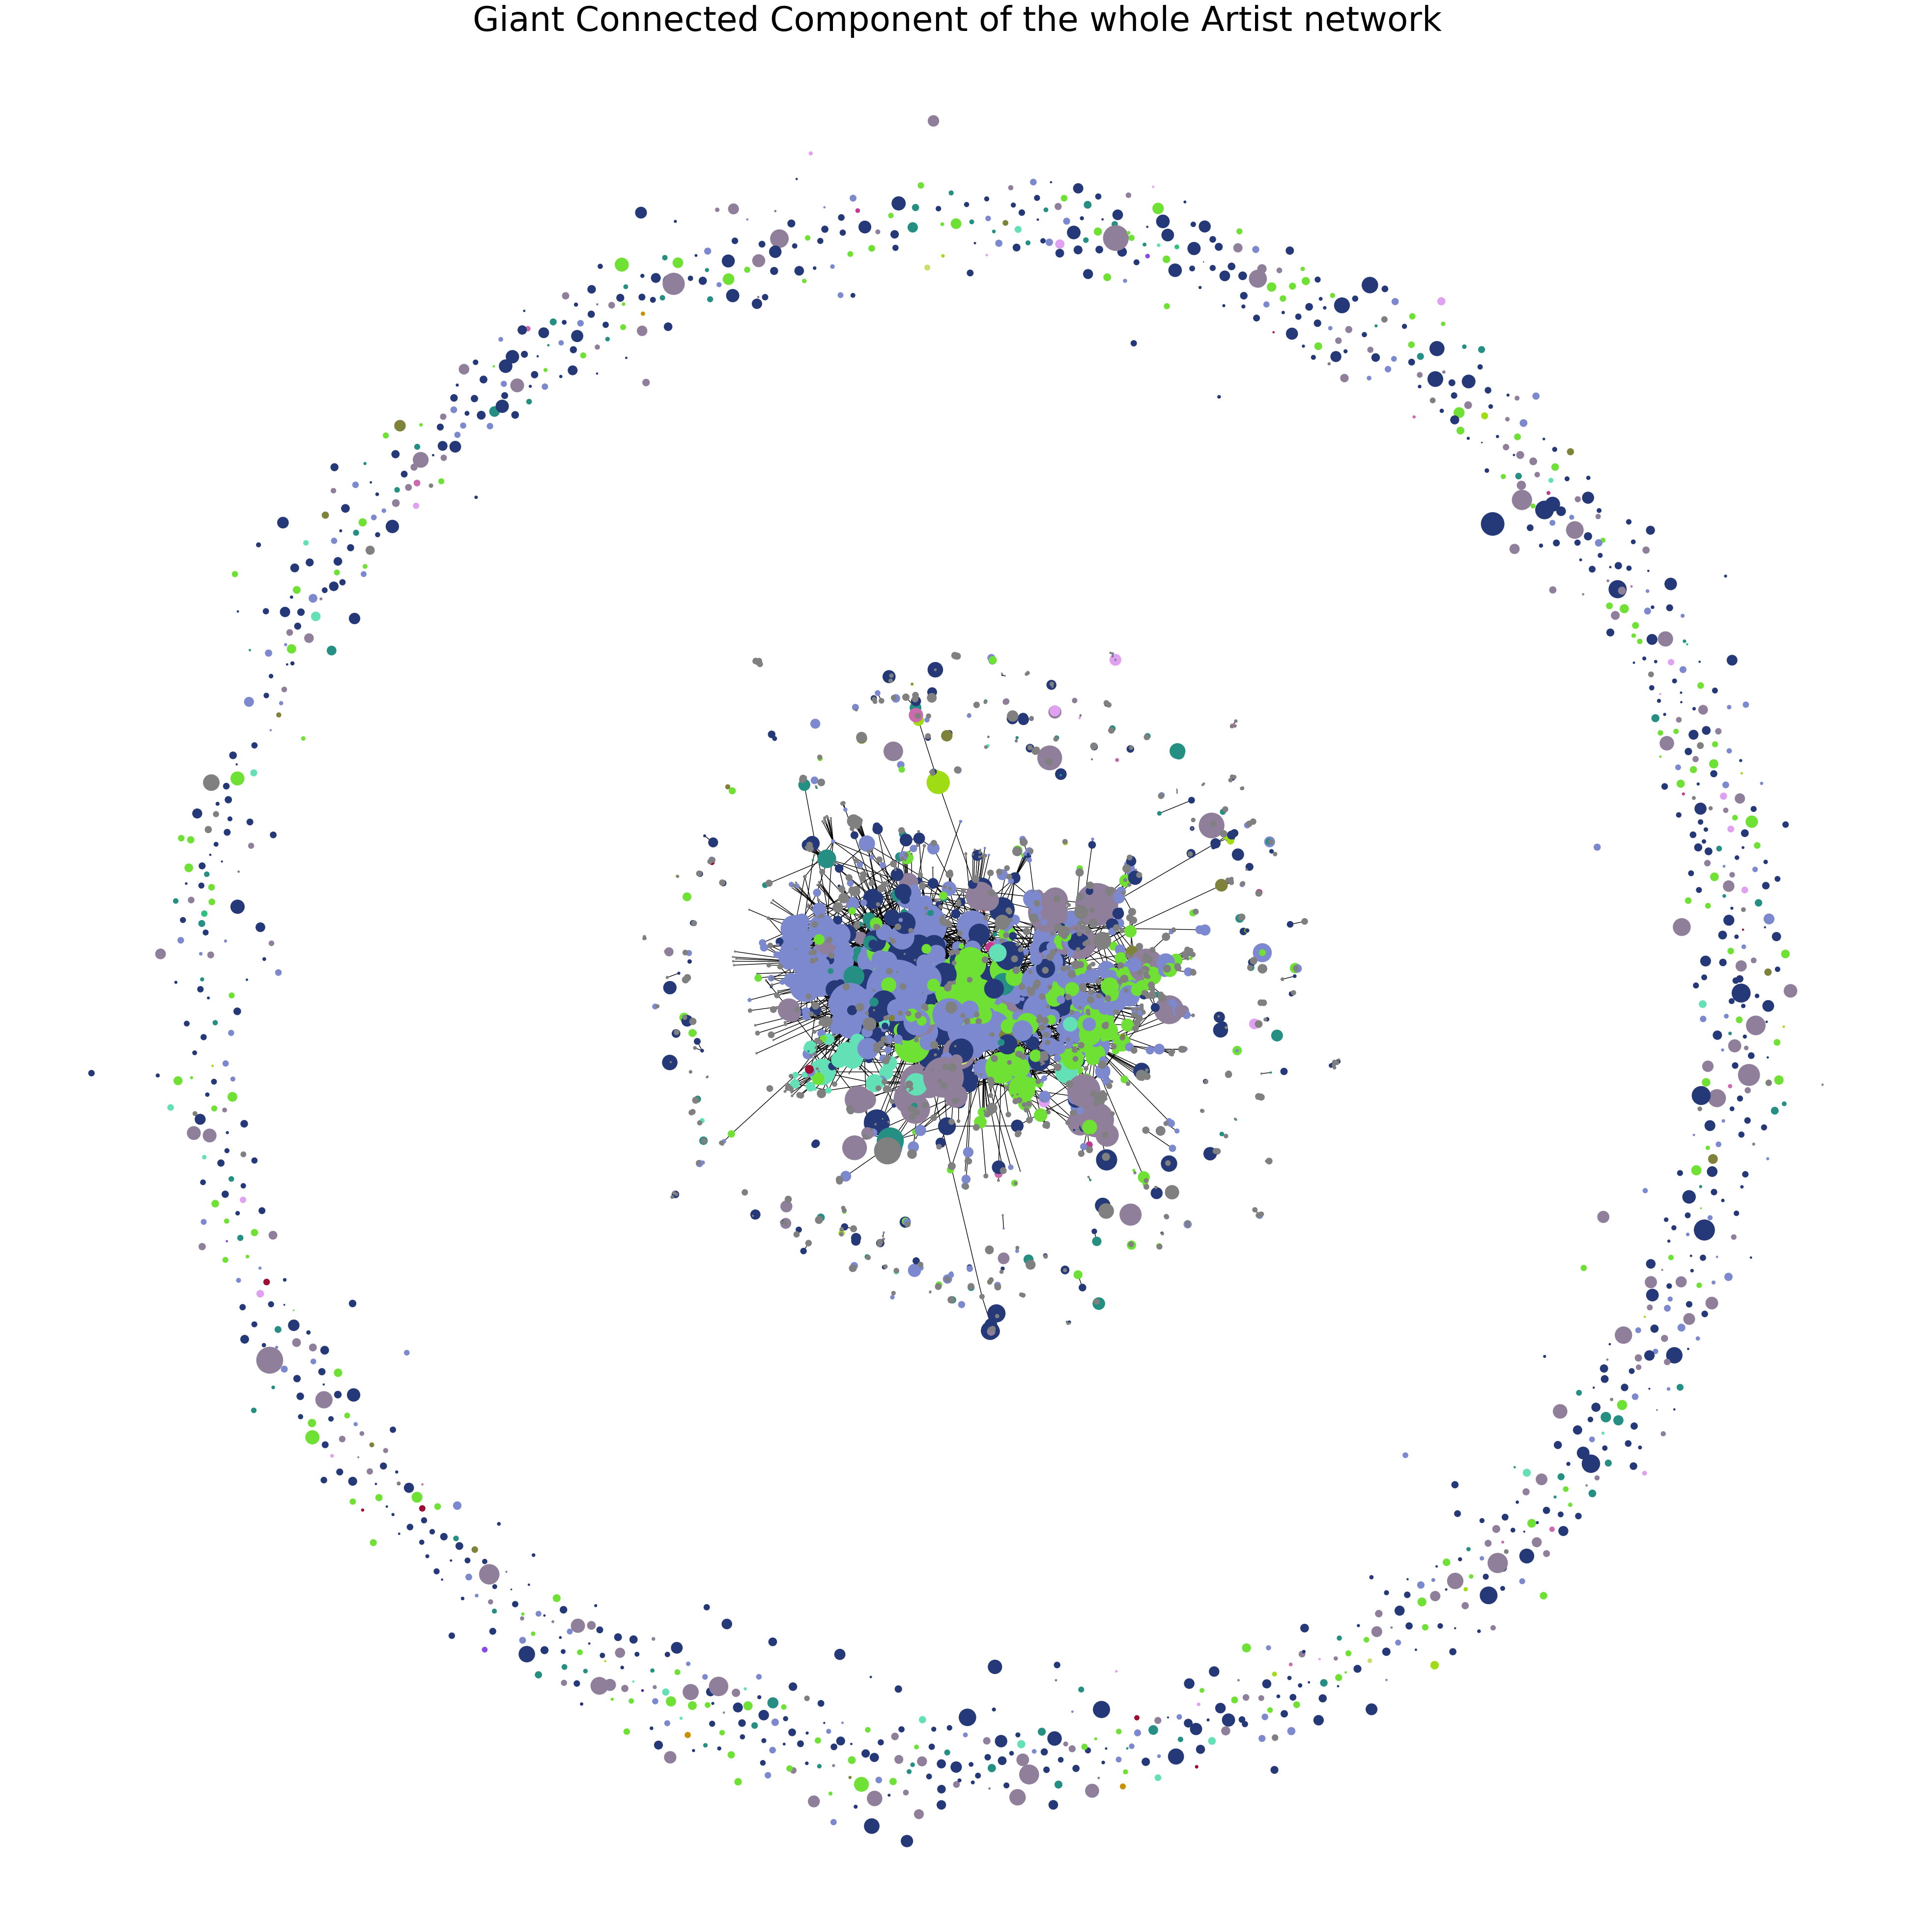

In [41]:
fig = plt.figure(1, figsize=(50, 50))

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,
                        

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=0.05,

                        # Log
                        verbose=True)



positions = forceatlas2.forceatlas2_networkx_layout(G,pos=None, iterations=50) #try to also change pos var to None

nx.draw_networkx_nodes(G, positions, node_size=node_size, node_color=node_colors, alpha=1)

nx.draw_networkx_edges(G, positions, edge_color="#000000", alpha=1)

plt.title("Giant Connected Component of the whole Artist network", fontsize=50)
plt.axis('off')
plt.show()

100%|██████████| 50/50 [00:01<00:00, 30.44it/s]


BarnesHut Approximation  took  0.47  seconds
Repulsion forces  took  1.08  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.03  seconds


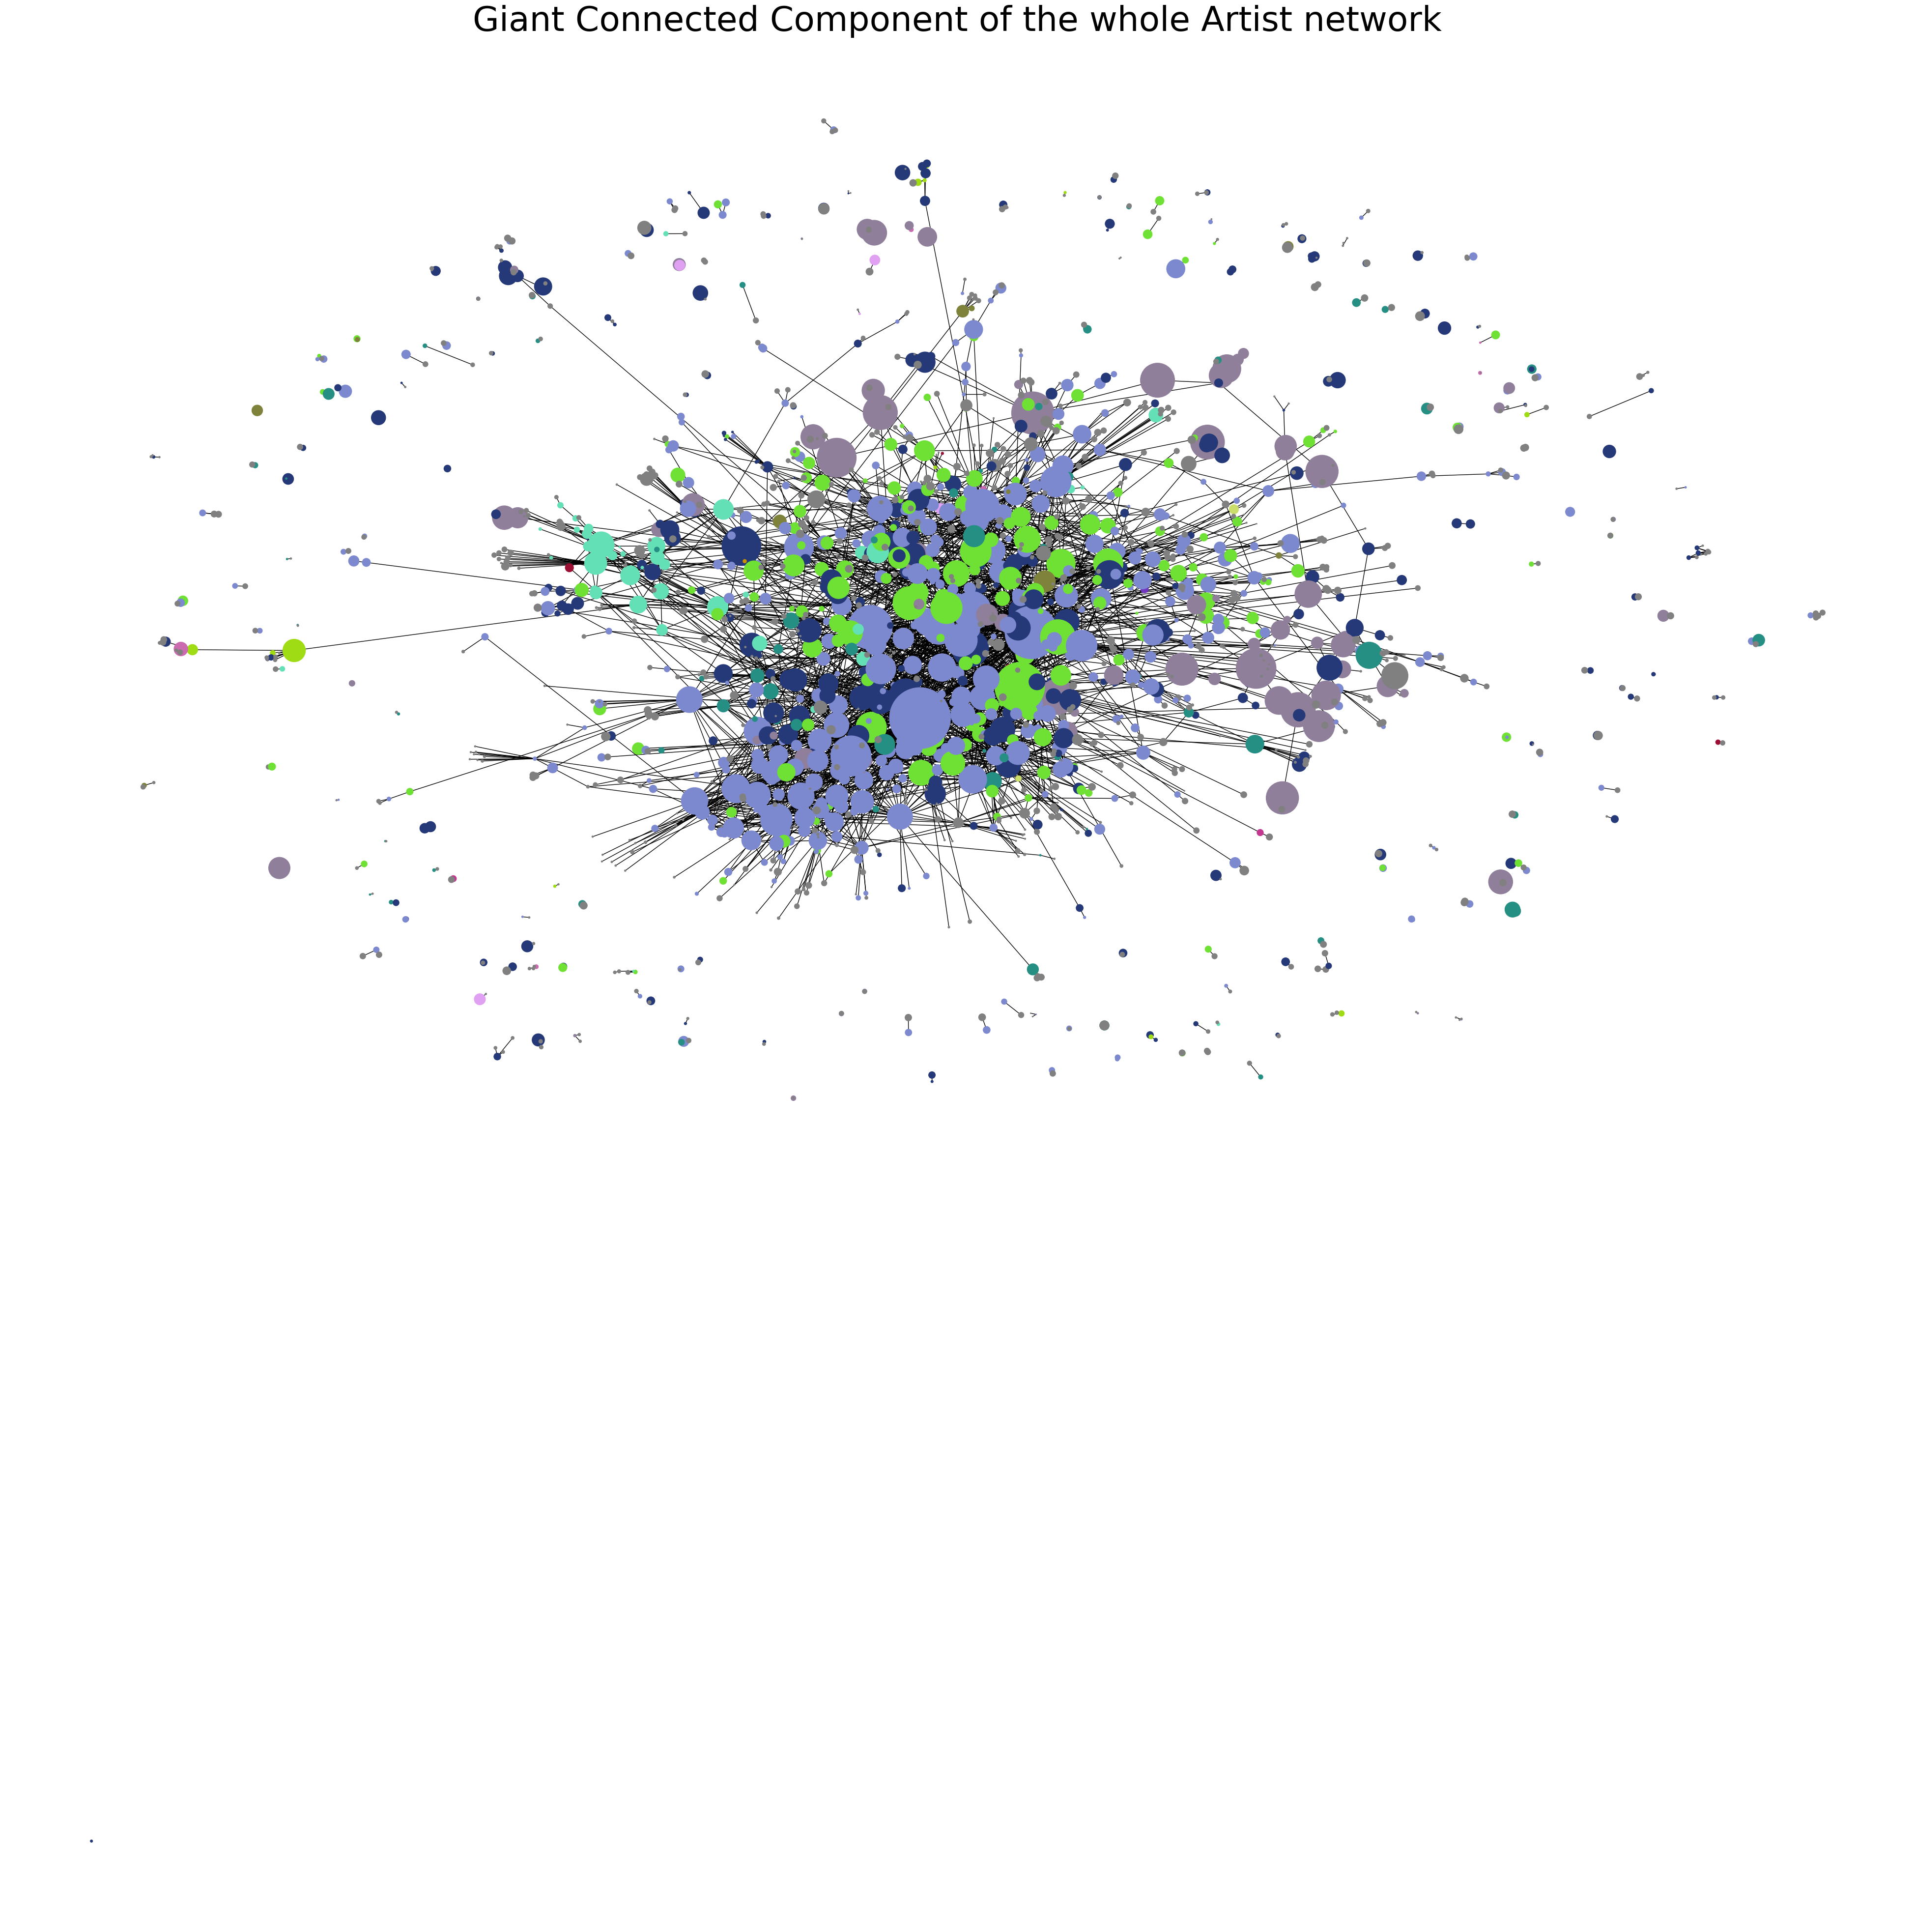

In [69]:
fig = plt.figure(1, figsize=(50, 50))

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,
                        

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=0.05,

                        # Log
                        verbose=True)



positions2 = forceatlas2.forceatlas2_networkx_layout(G2,pos=None, iterations=50) #try to also change pos var to None

nx.draw_networkx_nodes(G2, positions2, node_size=node_size_2, node_color=node_colors_2, alpha=1)

nx.draw_networkx_edges(G2, positions2, edge_color="#000000", alpha=1)

plt.title("Giant Connected Component of the whole Artist network", fontsize=50)
plt.axis('off')
plt.show()

**Network Interpretation**

We have made two network plots to understand the relationship between the artists who have collaborated and those who have not collaborated but are famous (i.e. Adele). In some of the nodes in the network are quite sparse, it could mean that there are certain artists or bands that do not have many connections to other artists or bands. These isolated nodes may represent solo artists who do not collaborate with other musicians very often.

If we were to eliminate these isolated nodes from the network, we might be able to see that certain genres of music, such as rap, have a strong sense of collaboration. This would support the expectation that rap music often involves multiple artists working together on a single track or project.

Overall, a large network of artists can provide insight into the relationships and collaborations within the music industry, and can help us understand the dynamics of different genres of music

<a id='Assortativity_features'></a>
# Assortativity between features and artist attributes

In this section we will look at the assortativity between the edges representing features, and the two artist attributes **Genre**, and **Rank Score**

<a id='Assortativity_features_rank_score'></a>
## Assortivity between features and Rank Score

We first create a rank score. We want a score that captures both how long the song has been on the billboard (just a week, or maybe even a year?) and how high it has been placed in that time (slumming it at no. \#1 , or getting grammys at \#1?).

Here we create the rank score. One week at \#1 gives 100 points, and 1 week at \#100 gives 1 point. We then sum the scores over all the weeks, to get a final score

In [70]:
#Get only necesarry features
rank_df=df[['year','rank','all_artists','song']]
#Reverse the rank, this way the highest ranked song gets the most points
rank_df['rank_score']=101-rank_df['rank']
#Get number of features on the song
rank_df['no_features']=rank_df['all_artists'].apply(lambda x: len(x))
#Explode dataframe, so feature artist can get points as well
explode= rank_df.explode('all_artists').reset_index(drop=True)
#Remove unnecessary columns
rank_df=explode[['rank','all_artists']]
#Group over time and sum score
rank_df=rank_df.groupby(['all_artists']).sum()
rank_df=rank_df.reset_index()

<a id='Assortativity years'></a>
#### Assortativity over the years

We will take a look at assortativity between artist with relation to the rank score. Our artist are conncted by songs they have featured together on. In other words assortativity in this case tells us if artist with high rank scores are mostly working with other artist who have high rank score (or perhaps the other way around

In [71]:
#Get all the years so we can see the development
years=list(df.year.unique())
years.sort()
feauture_df=df[['artist_0','features','year']]

#We create a dictionary. The keys will be years and the values will be dictionaries containing nodes and edges
#for that year
graphs={}

for year in years:
    #get only nodes and edges which are present up until the current year we are lookinng at
    tmp_df=feauture_df[feauture_df['year']<=year]
    #Just a quick security check for nan and empty values
    tmp_df['artist_0'].replace('', np.nan, inplace=True)
    tmp_df.dropna(inplace=True)
    
    #explode frame so we get all edge pairs, and store edges and node
    artist_explode = tmp_df.explode('features').reset_index(drop=True)
    artist_explode['features'].replace('', np.nan, inplace=True)
    artist_explode.dropna(inplace=True)
    uni_edges = list(artist_explode[['artist_0','features']].itertuples(index=False, name=None))
    
    #insert into dictionary
    graphs[year]={'nodes':tmp_df['artist_0'].values,'edges':set(uni_edges)}

In [72]:
#get the years, but this time we would like to use them for plotting as well, so we reverse it
years=list(df.year.unique())
years.reverse()

#get assortativity score and indec
assortativy_index, year_graph = [], []

#loop over years
for y in years:
    #Create graph and get edges.
    G=nx.Graph()
    G.add_nodes_from(set(graphs[y]['nodes']))
    G.add_edges_from(set(graphs[y]['edges']))
    #We know bin the rank score so we can use it as and attribute, and insert into the graph as an attribute
    attr={}
    #loop over all nodes
    for node in G.nodes:
        if len(rank_df[rank_df['all_artists']==node]['rank'].values)>0:
            attr[node]={'rank_score':rank_df[rank_df['all_artists']==node]['rank'].values[0]}
        else:
            attr[node]={'rank_score':1}
    
    #Set the node attribute
    nx.set_node_attributes(G,attr)
    #get a list of all scores
    scores=[i['rank_score'] for i in list(attr.values())]
    
    #We want bins that take into account that there are a lot of nodes with a relatively low score (0-100)
    #and as we go up in rank values we get less nodes, so we need gradually increasing bin sizes.
    #for this we create bins which are roughly 2**i, of the bin index, which we found to be quite a nice fit
    bins=[0,100,250, 500,1000,2000]
    
    #Create dict of rank score bin
    bin_attr={}
    for key,value in attr.items():
        for i in range(len(bins)):
            
            #These are the ones with the highest score
            if i!=len(bins)-1 and bins[i]<=value['rank_score']<bins[i+1]:
                bin_attr[key]={'ranks_score':i+1}
            
            #Give score according to bin
            elif i==len(bins)-1 and bins[i]<=value['rank_score']:
                bin_attr[key]={'ranks_score':i+1}
    #Set the binned rank score
    nx.set_node_attributes(G,bin_attr)
    #Calculate assortativity
    results = nx.numeric_assortativity_coefficient(G, "ranks_score")
    
    #storing results
    year_graph.append(y)
    assortativy_index.append(results)

#assortativity score to dataframe
asso_results_feat = pd.DataFrame({'year' : year_graph, 'coeffiecient':assortativy_index })
    

In [73]:
asso_results_feat

year  coeffiecient
0   1996      0.174592
1   1997      0.218706
2   1998      0.341971
3   1999      0.339725
4   2000      0.286114
5   2001      0.280766
6   2002      0.245828
7   2003      0.223854
8   2004      0.252317
9   2005      0.258693
10  2006      0.263203
11  2007      0.254558
12  2008      0.255023
13  2009      0.246415
14  2010      0.228395
15  2011      0.226445
16  2012      0.226616
17  2013      0.248599
18  2014      0.241577
19  2015      0.238363
20  2016      0.235700
21  2017      0.248419
22  2018      0.253338
23  2019      0.272135
24  2020      0.253819
25  2021      0.228488

<a id='Genre_features'></a>
# Assortativity between features and Genre

In [74]:
#get the years, but this time we would like to use them for plotting as well, so we reverse it
years=list(df.year.unique())
years.reverse()

#get assortativity score and indec
assortativy_index, year_graph = [], []

artist_with_genre = genre["artist"].values.tolist()

#loop over years
for y in years:
    #Create graph and get edges.
    G=nx.Graph()
    G.add_nodes_from(set([i for i in graphs[y]['nodes'] if i in artist_with_genre]))
    G.add_edges_from(set(graphs[y]['edges']))
    #We know bin the rank score so we can use it as and attribute, and insert into the graph as an attribute
    attr={}
    #loop over all nodes
    for node in G.nodes:
        #len(genre[genre['artist']==node]['genre'].values)>0 and 
        if node in artist_with_genre:
            attr[node]={'genre':genre[genre['artist']==node]['genre'].values[0]}
    
    #Set the node attribute
    nx.set_node_attributes(G,attr)
    #get a list of all scores
    scores=[i['genre'] for i in list(attr.values())]
    
    #Calculate assortativity
    results = nx.attribute_assortativity_coefficient(G, "genre")
    
    #storing results
    year_graph.append(y)
    assortativy_index.append(results)

#assortativity score to dataframe
asso_results_genre = pd.DataFrame({'year' : year_graph, 'coeffiecient':assortativy_index })

**Interpretation Assortativity with Genre and Feats.**

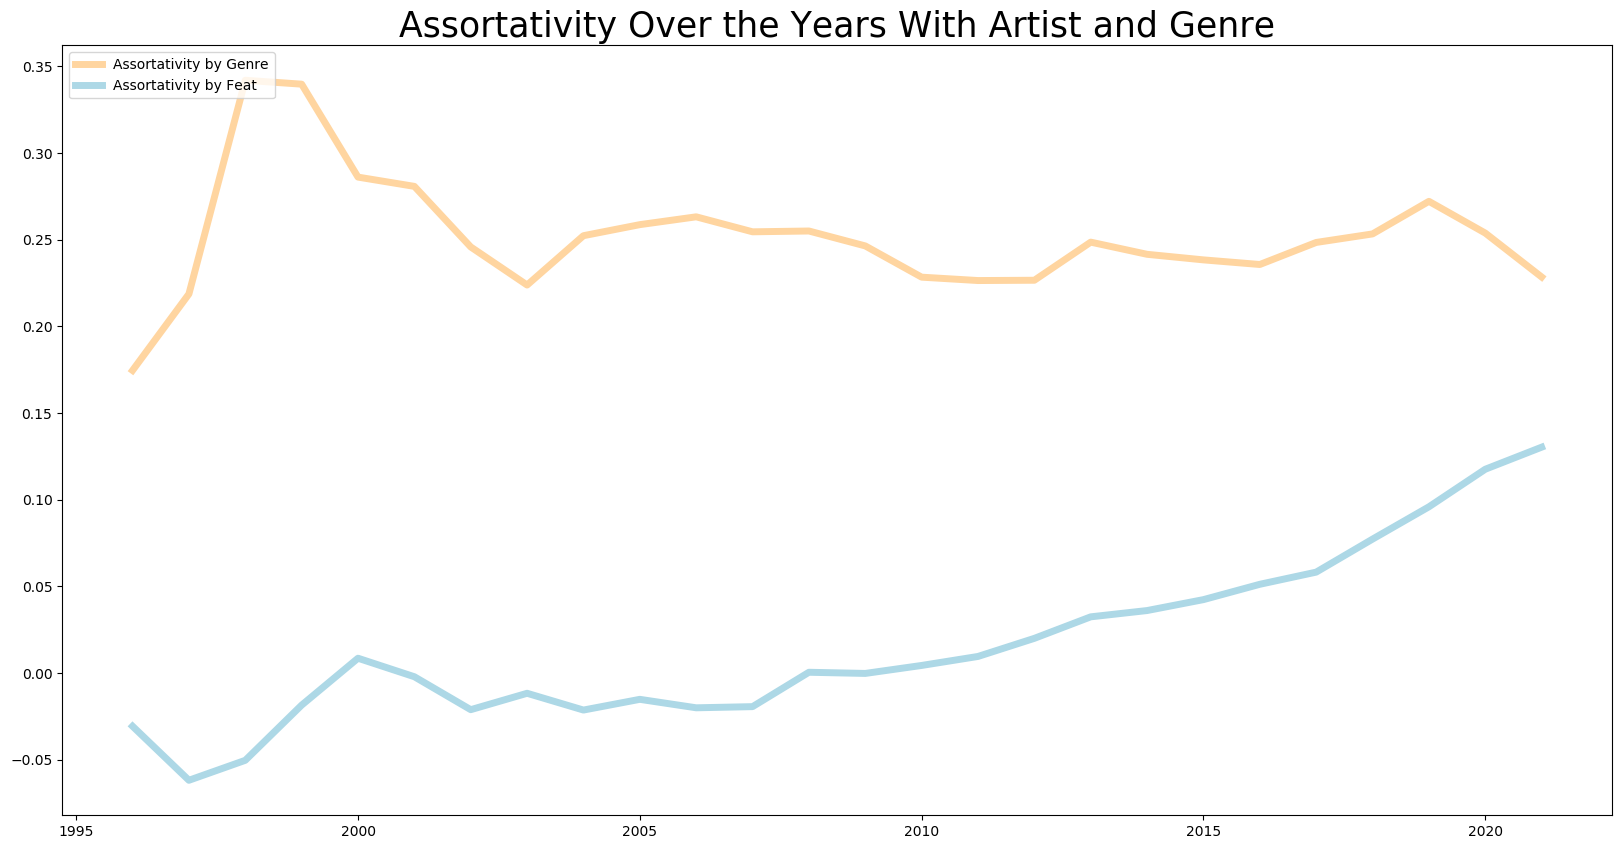

In [75]:
asso_results =  pd.merge(asso_results_genre,asso_results_feat,on='year', how='left')
asso_results.rename(columns={'coeffiecient_x': 'Assortativity_genre','coeffiecient_y': 'Assortativity_feat' }, inplace =True)

x = asso_results.year



fig = plt.gcf()
fig.set_size_inches(20, 10)


ax1 = plt.plot(x, asso_results['Assortativity_feat'], color = '#FFD5A0',linewidth=5.0)
ax2 = plt.plot(x, asso_results['Assortativity_genre'], color = 'lightblue',linewidth=5.0)
plt.title('Assortativity Over the Years With Artist and Genre', size = 25)
#assigning legends for the plot
period = ['Assortativity by Genre','Assortativity by Feat']
plt.legend(period,loc=2)
plt.show()

<a id='Lyrics_assortativity'></a>
# Lyrics Assortativity

Lets look if there is assortativity between the similarity of the lyrics text and the artist attributes.
In other words do high ranking artists have similar lyrics to other high ranking artists (or the other way around)? Or do artists with the same genre have similar lyrics to other artists within the genre?

**The similarity scoring is based on [Caractacus](https://www.kaggle.com/code/caractacus/thematic-text-analysis-using-spacy-networkx/notebook)** 

In [76]:
#Get all lyrics
path = '/Users/gustavfranck/DTU/networks/music_networks/clean_lyrics'
csv_files = glob.glob(os.path.join(path, "*.txt"))
songs=[]
  
# loop over the list of csv files
for f in csv_files:
    #Get the song title
    song=f.split('/')[7].strip('.txt')
    
    with open(f) as file:
        lyric=file.read()
    #append a tuple containing song name and lyric
    songs.append((song,lyric))


In [78]:
#Now we have a frame containing song and artist name for every lyrics
lyrics_df = pd.DataFrame(songs, columns =['song', 'lyrics'])
lyrics_df

song  \
0                 Real Hitta_Plies Featuring Kodak Black   
1                      Scotch And Soda_The Kingston Trio   
2                                   #9 Dream_John Lennon   
3                           Close To Cathy_Mike Clifford   
4                            Zip Code_The Five Americans   
...                                                  ...   
22144                   Land Of 1000 Dances_Wilson Picke   
22145                                       ABC_Glee Cas   
22146                     Under The Milky Way_The Church   
22147  You Can Never Stop Me Loving You_Johnny Tillotson   
22148  One Shot_YoungBoy Never Broke Again Featuring ...   

                                                  lyrics  
0      yeah baby im certified smacker plies kodak im ...  
1      scotch soda mud eye baby feel high oh oh feel ...  
2      long ago dream dream know yes know seemed real...  
3      mike clifford peak chart position music bob go...  
4      zip zip zip code zip code postman says faster ...  
...                                                  ...  
22144  send im gon send land land thousand dances ow ...  
22145  buhbuh buh buhbuh buhbuh buh buhbuh went schoo...  
22146  sometimes place gets kind empty sound breath f...  
22147  go around tell others darling know one thing c...  
22148                                                     

[22149 rows x 2 columns]

In [79]:
#Split song name and artist(s) into seperate columns
lyrics_df['artist'] = lyrics_df.song.apply(lambda x: x.split('_')[1])
lyrics_df['song_name']=lyrics_df.song.apply(lambda x: x.split('_')[0])
lyrics_df

song  \
0                 Real Hitta_Plies Featuring Kodak Black   
1                      Scotch And Soda_The Kingston Trio   
2                                   #9 Dream_John Lennon   
3                           Close To Cathy_Mike Clifford   
4                            Zip Code_The Five Americans   
...                                                  ...   
22144                   Land Of 1000 Dances_Wilson Picke   
22145                                       ABC_Glee Cas   
22146                     Under The Milky Way_The Church   
22147  You Can Never Stop Me Loving You_Johnny Tillotson   
22148  One Shot_YoungBoy Never Broke Again Featuring ...   

                                                  lyrics  \
0      yeah baby im certified smacker plies kodak im ...   
1      scotch soda mud eye baby feel high oh oh feel ...   
2      long ago dream dream know yes know seemed real...   
3      mike clifford peak chart position music bob go...   
4      zip zip zip code zip code postman says faster ...   
...                                                  ...   
22144  send im gon send land land thousand dances ow ...   
22145  buhbuh buh buhbuh buhbuh buh buhbuh went schoo...   
22146  sometimes place gets kind empty sound breath f...   
22147  go around tell others darling know one thing c...   
22148                                                      

                                              artist  \
0                        Plies Featuring Kodak Black   
1                                  The Kingston Trio   
2                                        John Lennon   
3                                      Mike Clifford   
4                                 The Five Americans   
...                                              ...   
22144                                   Wilson Picke   
22145                                       Glee Cas   
22146                                     The Church   
22147                               Johnny Tillotson   
22148  YoungBoy Never Broke Again Featuring Lil Baby   

                              song_name  
0                            Real Hitta  
1                       Scotch And Soda  
2                              #9 Dream  
3                        Close To Cathy  
4                              Zip Code  
...                                 ...  
22144               Land Of 1000 Dances  
22145                               ABC  
22146               Under The Milky Way  
22147  You Can Never Stop Me Loving You  
22148                          One Shot  

[22149 rows x 4 columns]

In [80]:
#A filte to only get songs we are working with (year>1995)
filter_df=df[['song','Raw_artist']]
filter_df.rename(columns={'song':'song_name','Raw_artist':'artist'},inplace=True)
keys=list(filter_df.columns.values)

i1=lyrics_df.set_index(keys).index
i2 = filter_df.set_index(keys).index

new_lyrics_df=lyrics_df[i1.isin(i2)]
new_lyrics_df=new_lyrics_df[['artist','lyrics','song_name']]
new_lyrics_df

artist  \
0                        Plies Featuring Kodak Black   
6                                             Miguel   
7                                       Maddie & Tae   
11                                         Meek Mill   
14                                          S Club 7   
...                                              ...   
22138                                     Gary Allan   
22139          Timbaland Featuring Justin Timberlake   
22141                                 Dierks Bentley   
22143                             Dave Matthews Band   
22148  YoungBoy Never Broke Again Featuring Lil Baby   

                                                  lyrics  \
0      yeah baby im certified smacker plies kodak im ...   
6      mami looking like im another guy came check ca...   
7      country music harmed making song testtt well w...   
11     brrr every time get back streets shit get dark...   
14     oohooh ooh everybodys got something leave behi...   
...                                                  ...   
22138  sittin hood truck lookin caramel colored sunse...   
22139  alright hey clap oh need girl hey really need ...   
22141  strange hear voice expect call wonder im im ho...   
22143  quit quickly theres hope corner could squeeze ...   
22148                                                      

                         song_name  
0                       Real Hitta  
6                          Quickie  
7           Girl In A Country Song  
11              Intro (Hate On Me)  
14     Never Had A Dream Come True  
...                            ...  
22138           Watching Airplanes  
22139                      Release  
22141               How Am I Doin'  
22143            The Space Between  
22148                     One Shot  

[7018 rows x 3 columns]

In [81]:
filter_df=df[['song','Raw_artist','all_artists']]
filter_df.rename(columns={'song':'song_name','Raw_artist':'artist'},inplace=True)
filter_df

song_name                               artist  \
0         Easy On Me                                Adele   
1               Stay        The Kid LAROI & Justin Bieber   
2         Fancy Like                         Walker Hayes   
3         Bad Habits                           Ed Sheeran   
4         Way 2 Sexy  Drake Featuring Future & Young Thug   
...              ...                                  ...   
330074  Shadowboxin'      Genius/GZA Featuring Method Man   
330075  Shadowboxin'      Genius/GZA Featuring Method Man   
330076  Shadowboxin'      Genius/GZA Featuring Method Man   
330077    Cold World  Genius/GZA Featuring Inspektah Deck   
330078    Cold World  Genius/GZA Featuring Inspektah Deck   

                           all_artists  
0                              [Adele]  
1       [The Kid LAROI, Justin Bieber]  
2                       [Walker Hayes]  
3                         [Ed Sheeran]  
4          [Drake, Future, Young Thug]  
...                                ...  
330074        [Genius/GZA, Method Man]  
330075        [Genius/GZA, Method Man]  
330076        [Genius/GZA, Method Man]  
330077    [Genius/GZA, Inspektah Deck]  
330078    [Genius/GZA, Inspektah Deck]  

[134900 rows x 3 columns]

In [82]:
#Merge clean feautures and main artist onto frame
merge =pd.merge(new_lyrics_df,filter_df,how='left',on=['song_name','artist'])


merge.drop_duplicates(subset=['artist','lyrics','song_name'],inplace=True)

merge=merge[['all_artists','lyrics']]


merge['all_artists'] = merge['all_artists'].astype('str')
merge['lyrics'] = merge['lyrics'].astype('str')

merge['all_artists'] = merge.all_artists.apply(lambda x: x[1:-1].split(','))

merge

all_artists  \
0                        ['Plies',  'Kodak Black']   
1                                       ['Miguel']   
15                              ['Maddie',  'Tae']   
35                                   ['Meek Mill']   
36                                    ['S Club 7']   
...                                            ...   
93625                               ['Gary Allan']   
93645          ['Timbaland',  'Justin Timberlake']   
93646                           ['Dierks Bentley']   
93662                       ['Dave Matthews Band']   
93685  ['YoungBoy Never Broke Again',  'Lil Baby']   

                                                  lyrics  
0      yeah baby im certified smacker plies kodak im ...  
1      mami looking like im another guy came check ca...  
15     country music harmed making song testtt well w...  
35     brrr every time get back streets shit get dark...  
36     oohooh ooh everybodys got something leave behi...  
...                                                  ...  
93625  sittin hood truck lookin caramel colored sunse...  
93645  alright hey clap oh need girl hey really need ...  
93646  strange hear voice expect call wonder im im ho...  
93662  quit quickly theres hope corner could squeeze ...  
93685                                                     

[7018 rows x 2 columns]

In [83]:
#get the text for all artist that worked on the song
explode= merge.explode('all_artists').reset_index(drop=True)
explode.replace('', np.nan, inplace=True)

In [84]:
explode=explode.dropna()
explode

all_artists                                             lyrics
0                  'Plies'  yeah baby im certified smacker plies kodak im ...
1            'Kodak Black'  yeah baby im certified smacker plies kodak im ...
2                 'Miguel'  mami looking like im another guy came check ca...
3                 'Maddie'  country music harmed making song testtt well w...
4                    'Tae'  country music harmed making song testtt well w...
...                    ...                                                ...
9331          'Gary Allan'  sittin hood truck lookin caramel colored sunse...
9332           'Timbaland'  alright hey clap oh need girl hey really need ...
9333   'Justin Timberlake'  alright hey clap oh need girl hey really need ...
9334      'Dierks Bentley'  strange hear voice expect call wonder im im ho...
9335  'Dave Matthews Band'  quit quickly theres hope corner could squeeze ...

[9102 rows x 2 columns]

In [85]:
#Group all song lyrics for a single artist into one document/string
explode=explode.groupby(['all_artists'], as_index=False).agg({'lyrics': ' '.join})
explode

all_artists  \
0      "Brandy 'Ms. B.' Hambrick"   
1                 "Colby O'Donis"   
2                      "D'Angelo"   
3                   "Lil' Boosie"   
4                     "Lil' Flip"   
...                           ...   
2873              'lovelytheband'   
2874                'matchbox 20'   
2875            'matchbox twenty'   
2876          'twenty one pilots'   
2877                  'will.i.am'   

                                                 lyrics  
0     nie meeny miney moe many bitches club want go ...  
1     see run words say ahh wouldnt leave cause your...  
2     really baby really baby girl know drive crazy ...  
3     independent know mean mayne independent know m...  
4     straight atl got yung wun choppin thing baby s...  
...                                                 ...  
2873  like youre broken broken like maybe makes fool...  
2874  well wonder like rainmaker wonder like know ma...  
2875  day starin ceilin makin friends shadows wall n...  
2876  msilaiv ecnuoned ew tsae eurt daeh dna amed ev...  
2877  make world make world go round turn turn upsid...  

[2878 rows x 2 columns]

In [86]:
explode['all_artists']=explode.all_artists.apply(lambda x: x.strip(' ')[1:-1])

In [87]:
#Load spacy language model
nlp = spacy.load('en_core_web_md') 

In [88]:
#Parse document through language model
parsed_doc = []

for doc in nlp.pipe(explode['lyrics'].astype('unicode').values, batch_size=50,
                        n_threads=3):
    if doc.is_parsed:
        parsed_doc.append(doc)


explode['parsed_doc'] = parsed_doc


In [89]:
#We calculate the cosine similarity for all documents against all other documents. 
#The similarity score will be the edge weight. This means we create N*(N-1)/2 edges
G=nx.Graph()

for doc1,song1 in explode[['parsed_doc','all_artists']].itertuples(index=False):
    for doc2,song2 in explode[['parsed_doc','all_artists']].itertuples(index=False):
        if song1 != song2:
            if not G.has_edge(song2,song1):
                G.add_edge(song1, song2, weight = doc1.similarity(doc2))

<a id='Backboning'></a>
## Backboning
We backbone the network to only get relevant edges.

**We use the backboning methods from
[aekpalakorn](https://github.com/aekpalakorn)**

In [90]:
#we create a score to use for backboning, as done by:
def disparity_filter(G, weight='weight'):
    B = nx.Graph()
    for u in G:
        k = len(G[u])
        if k > 1:
            sum_w = sum(np.absolute(G[u][v][weight]) for v in G[u])
            for v in G[u]:
                w = G[u][v][weight]
                p_ij = float(np.absolute(w))/sum_w
                alpha_ij = 1 - (k-1) * integrate.quad(lambda x: (1-x)**(k-2), 0, p_ij)[0]
                B.add_edge(u, v, weight = w, alpha=float('%.4f' % alpha_ij))
    return B

In [91]:
#Create disparity filter
disparity_filte=disparity_filter(G)

In [92]:
#Cut unwanted edges
def disparity_filter_alpha_cut(G,weight='weight',alpha_t=0.34, cut_mode='or'):

    B = nx.Graph()#Undirected case:   
    for u, v, w in G.edges(data=True):

        try:
            alpha = w['alpha']
        except KeyError: #there is no alpha, so we assign 1. It will never pass the cut
            alpha = 1

        if alpha<alpha_t:
            B.add_edge(u,v, weight=w[weight])
    return B                

In [93]:
#Final backboned graph
backbone=disparity_filter_alpha_cut(disparity_filte)

<a id='Assortativity_lyrics_rank_score'></a>
## Assortivity between lyrics similarity and Rank Score

In [94]:
#Set rank score attribute
attr={}
for node in backbone.nodes:
    #attr[node]={'genre':genres[genres['artist']==node]}
    if len(rank_df[rank_df['all_artists']==node]['rank'].values)>0:
        attr[node]={'rank_score':rank_df[rank_df['all_artists']==node]['rank'].values[0]}
    else:
        attr[node]={'rank_score':1}
        
nx.set_node_attributes(backbone,attr)

In [95]:
#Lets check the sorted scores
scores=[i['rank_score'] for i in list(attr.values())]

sorted(attr.items(), key=lambda x: x[1]['rank_score'], reverse=True)

[('Drake', {'rank_score': 119707}),
 ('Lil Wayne', {'rank_score': 88855}),
 ('Chris Brown', {'rank_score': 78970}),
 ('Nicki Minaj', {'rank_score': 62486}),
 ('Kenny Chesney', {'rank_score': 57678}),
 ('Future', {'rank_score': 52338}),
 ('Keith Urban', {'rank_score': 51292}),
 ('Taylor Swift', {'rank_score': 48700}),
 ('Rihanna', {'rank_score': 43720}),
 ('Brad Paisley', {'rank_score': 41033}),
 ('Beyonce', {'rank_score': 39107}),
 ('Blake Shelton', {'rank_score': 37932}),
 ('Ludacris', {'rank_score': 36326}),
 ('Usher', {'rank_score': 35583}),
 ('Rick Ross', {'rank_score': 34074}),
 ('Luke Bryan', {'rank_score': 33939}),
 ('Carrie Underwood', {'rank_score': 33639}),
 ('Justin Bieber', {'rank_score': 32954}),
 ('Lil Baby', {'rank_score': 32469}),
 ('Trey Songz', {'rank_score': 31867}),
 ('R. Kelly', {'rank_score': 30775}),
 ('Eminem', {'rank_score': 30715}),
 ('Pitbull', {'rank_score': 30256}),
 ('The Weeknd', {'rank_score': 29945}),
 ('2 Chainz', {'rank_score': 28770}),
 ('T-Pain', {'

In [96]:
#Create bins as described in the other assortativity section, and do the same process
bins=[0,100,250, 500,1000,2000]

bin_attr={}
for key,value in attr.items():
    for i in range(len(bins)):
        
        if i!=len(bins)-1 and bins[i]<=value['rank_score']<bins[i+1]:
            bin_attr[key]={'rank_score':i+1}
            
        
        elif i==len(bins)-1 and bins[i]<=value['rank_score']:
            bin_attr[key]={'rank_score':i+1}
            
            
            

In [97]:
#set the attributes and calculate the assortativity score
nx.set_node_attributes(backbone,bin_attr)

nx.attribute_assortativity_coefficient(backbone, "rank_score")

-0.026323884259670673

<a id='Assortativity_lyrics_genre'></a>
## Assortivity between lyrics similarity and genre

In [98]:
artist_with_genre = genre["artist"].values.tolist()

genre_attr={}
count=0
for node in backbone.nodes:
    #len(genre[genre['artist']==node]['genre'].values)>0 and 
    if node in artist_with_genre:
        genre_attr[node]={'genre':genre[genre['artist']==node]['genre'].values[0]}
        
#Set the node attribute
nx.set_node_attributes(backbone,genre_attr)


In [99]:
nx.attribute_assortativity_coefficient(backbone, "genre")

0.05909573486016997

# Sentiment Analysis

In [271]:
df_song = df[~(df['year'] <= 1995)]

df_song=df_song.assign(
    song_artist=df_song[['song','artist_0']].apply(
        lambda row: '_'.join([str(each) for each in row]),axis=1))

In [290]:
#loading lemmatizer
wnl = WordNetLemmatizer()

songs, text = [], []

for song in set(df_song.song_artist):
    try:
        with open(f'/Users/ale_muchinski/Library/CloudStorage/OneDrive-SharedLibraries-DanmarksTekniskeUniversitet/DTU - Projects - Documents/3. Semester/Social Graphs/Final Project/On going/music_networks/lyrics/{song}.txt') as f:
            data = f.read().replace('\n', ' ')

            song_name = song.split('.txt')[0]
            content=data.lower()
            #cutting api calling details (dirty data)
            content = content.split('lyrics', 1)[1]
            content = re.sub(r'\([^)]*\)', '',content)
            #cutting the last 8 digits (meaning embed)
            content = content[:-8]
            #removing punctuation
            content = re.sub('[^\w\s]','',content)
            #lemma
            content = wnl.lemmatize(content)
            #tokenization
            #token = word_tokenize(content)
            #appending hyperlinks and hero
            songs.append(song_name)
            text.append(content) 
            #tokens.append(token)

    except:
          pass 
songs1 = pd.DataFrame({'song_artist':songs,'raw_text':text})

In [291]:
f = pd.merge(songs1, df_song[['year', 'song_artist']], on="song_artist", how="right")

In [295]:
sid = SentimentIntensityAnalyzer()

years, pos, neg = [], [], []


for i in range(0, len(f.raw_text)):
    
    try: 
        pos_word_list = []
        neg_word_list = []
        neu_word_list = []
        
        sent = f['raw_text'][i]
        year = f['date'][i]
        
        #print(year)


        for word in sent.split():
            testimonial = TextBlob(word)
            if testimonial.sentiment.polarity >= 0.5:
                pos_word_list.append(word)
            elif testimonial.sentiment.polarity <= -0.5:
                neg_word_list.append(word)
            else:
                neu_word_list.append(word)
    
        #print(year)
        #text.append(sent)
        years.append(year)
        total = len(pos_word_list) + len(neg_word_list) + len(neu_word_list)
        pos.append(len(pos_word_list)/total)
        neg.append(len(neg_word_list)/total)
    
    except:
        pass
    

df_sent = pd.DataFrame({'years': years,'pos':pos, 'neg': neg})

In [296]:
df_sent

Empty DataFrame
Columns: [years, pos, neg]
Index: []

In [297]:
f

song_artist  \
0              Easy On Me_Adele   
1            Stay_The Kid LAROI   
2       Fancy Like_Walker Hayes   
3         Bad Habits_Ed Sheeran   
4              Way 2 Sexy_Drake   
...                         ...   
134895  Shadowboxin'_Genius/GZA   
134896  Shadowboxin'_Genius/GZA   
134897  Shadowboxin'_Genius/GZA   
134898    Cold World_Genius/GZA   
134899    Cold World_Genius/GZA   

                                                 raw_text  year  
0        there aint no gold in this river that ive bee...  2021  
1                                                     NaN  2021  
2        ayy my girl is bangin shes so low maintenance...  2021  
3         ooh ooh  every time you come around you know...  2021  
4                                                     NaN  2021  
...                                                   ...   ...  
134895                                                NaN  1996  
134896                                                NaN  1996  
134897                                                NaN  1996  
134898                                                NaN  1996  
134899                                                NaN  1996  

[134900 rows x 3 columns]

**Sentiment Analysis Results**

Looking just at the lyrics, the sentiment analysis's main purpose was to investigate the positive and negative words used in the lyrics. The percentage of positive and negative words was then grouped by year to show the trend. The result from this analysis was a decreasing trend of positive words through the years 1995-2021, while the trend of negative words was stable. Thereby, artists do not use as many positive words as they used to.

<a id='scraping'></a>
# Scraping

<a id='lyrics_scraping'></a>
## Lyrics scraping

In [ ]:
#File with song and artist name
with open('./song_artist.txt') as file:
    #go through each song/artist pair
    for line in file:
        #Parse out the artist and song
        song,artist=line.strip('\n').split("\',\'")
        #Some reqeusts wont go through, some songs are not in Genius (eg. old songs), so we try to query it,
        #and otherwise skip it
        try:
            #Query the api
            lyrics= genius.search_song(song, artist).lyrics
            #Write the contents to a a file in the lyrics directory
            with open(r'./lyrics/'+song+'_'+artist+'.txt', 'w') as fp:
        
                fp.write(lyrics)
            
        except:
            continue

#Ope the lyrics files we have just created
lyrics_directory = './lyrics'

#The Genius api will return adds and and other odd stuff instead of lyrics for a few songs.
#We keep track of the true lyrics count, just to know what we are dealing with
count_true=0
count_false=0

#loop over every lyrics in the directory
for filename in os.listdir(lyrics_directory):
    #Parse song and artist out of filename
    song,artist=filename.split('_')
    song=song.split('.txt')[0]

    
    f = os.path.join(lyrics_directory, filename)
    #Check that we do not have any hidden files
    if '.' in filename[0]:
        continue
    else:
        #open lyrics
        with open(f) as file:
            #As mentioned some lyrics will have odd stuff in them and will give a unicode error. We skip thoose
            try:
                #Read in file, ad get the caption from genius
                data = file.read()
                caption=data.split('\n')[0]
                #Clean the caption 
                caption=re.sub('[^A-Za-z0-9]+', '', caption.split('Lyrics')[0].lower().strip(' '))
                #Clean the song title
                song=re.sub('[^A-Za-z0-9]+', '', song.lower().strip(' '))
                #The genius caption needs to be the same as the song title.
                #If it is not, we know it is a "bad" file
                if song==caption:
                    f = open("./clean_lyrics/"+filename, "w")
                    f.write(str(data))
                    f.close
                    count_true+=1
                else:
                    print(caption, song)
                    count_false+=1
                
            except UnicodeDecodeError:
                continue
                
                
#Now we clean the lyrics 
#import stopwords, we do not need those for our analysis
stopwords=stopwords.words('english')
#loop over every lyrics in the directory
for filename in os.listdir(lyrics_directory):
    #Check that it is a text file and not a hidden file
    if '.txt' in filename:
        #create full path to file
        f = os.path.join(lyrics_directory, filename)
        with open(f) as file:
            #There is an embed line, we ust remove that straight away
            lyric=file.read().strip('Embed').replace('\n',' ').lower()
            #Remove numbers, in our analysis they will be difficult to work with.
            lyric=re.sub(r'[0-9]+', '', lyric)
            #We do a quite harsh cleaning. Lyrics differ very much in what they contain, 
            #so the approach here is "better safe than sorry"
            lyric = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", lyric)
            #Removig multiple spaces
            text_tokens = word_tokenize(lyric)
            text_tokens=(' ').join([i for i in text_tokens if i not in stopwords])
            f = open("./clean_lyrics/"+filename, "w")
            f.write(str(text_tokens))
            f.close
    else:
        continue


<a id='genres_scraping'></a>
## Genres scraping

In [ ]:
artists = df.artist_0.tolist()
artists = set(artists)

headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36'}

data = []

for artist in artists:
    try:
        url= urllib.request.urlopen("https://www.allmusic.com/search/artist/" + urllib.parse.quote(artist))
        soup = BeautifulSoup(requests.get(url.geturl(), headers=headers).content, "html.parser")
        link = soup.select_one("div.name a").get('href')
        soup = BeautifulSoup(requests.get(link, headers=headers).content, "html.parser")
        data.append({
            'artist':artist,
            'genre':soup.select_one("div.genre a").text,
            'link':link
        })
    except:
        continue

artists_genre = pd.DataFrame(data)
artists_genre.to_csv('artists_genre.csv')